In [51]:
#importing standard dependencies
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [52]:
# import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [53]:
#Avoid out of memory error by setting gpu consumption growth
gpus = tf.config.experimental,list_physical_devices("GPU")
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

NameError: name 'list_physical_devices' is not defined

Create Folder Structures

In [54]:
#Setup paths
NEG_PATH= os.path.join("data", "negative")
POS_PATH = os.path.join("data", "positive")
ANC_PATH = os.path.join("data", "anchor")

In [55]:
#Make directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [65]:
#uNcompress tar gz labelled faces in the wild dataset
!tar -xf lfw.tgz

tar: Error opening archive: Failed to open 'lfw.tgz'


In [ ]:
# move all the images in lfw directory to the negative folder
for directory in os.listdir("lfw"):
  for file in os.listdir(os.path.join("lfw", directory)):
    EX_PATH = os.path.join("lfw", directory, file)
    NEW_PATH = os.path.join(NEG_PATH, file)
    os.replace(EX_PATH, NEW_PATH)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'lfw'

In [67]:
#Import uuid library to generate unique image names
import uuid

In [68]:

# Establish a connection to webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
  ret, frame = cap.read()
  
  #cut down frame to 250x250 px
  frame = frame[120:120+250,200:200+250, :]
  
  #collect anchors
  if cv2.waitKey(1) & 0XFF == ord("a"):
    #create unique file path
    imgname=os.path.join(ANC_PATH,"{}.jpg".format(uuid.uuid1()))
    
    #write out anchor image
    cv2.imwrite(imgname,frame)
  
  #collect positives
  if cv2.waitKey(1) & 0XFF == ord("p"):
    #create unique file path
    imgname=os.path.join(POS_PATH,"{}.jpg".format(uuid.uuid1()))
    
    #write out positive image
    cv2.imwrite(imgname,frame)

  # Show image back to screen
  cv2.imshow("Image Collection", frame)

#Breaking gracefully
  if cv2.waitKey(1) & 0XFF == ord("q"):
    break

# Release the webcam
cap.release()

# Close the image show frame
cv2.destroyAllWindows()


In [57]:
#Get image directories
anchor = tf.data.Dataset.list_files(ANC_PATH +"\*.jpg").take(300)
positive = tf.data.Dataset.list_files(POS_PATH +"\*.jpg").take(300)
negative = tf.data.Dataset.list_files(NEG_PATH +"\*.jpg").take(300)

In [58]:
def preprocess(file_path):
    
    #Read in iage from file path
    byte_img=tf.io.read_file(file_path)
    
    #Load in the image
    img = tf.io.decode_jpeg(byte_img)
    
    #Resizing the image to 100x100x3
    img = tf.image.resize(img,(100,100))
    
    #Scaling image
    img=img/255.0
    return img

In [71]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [59]:
positives = tf.data.Dataset.zip((anchor,positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [60]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [61]:
# Build Dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [62]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [63]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(18)
test_data = test_data.prefetch(8)

## Model Engineering

In [64]:
def make_embedding():
    input = Input(shape=(100,100,3), name="input_image")
    c1 = Conv2D(64,(10,10), activation="relu")(input )
    m1 = MaxPooling2D(64,(2,2), padding="same")(c1)
    c2 = Conv2D(128,(7,7), activation="relu")(m1)
    m2 = MaxPooling2D(64,(2,2), padding="same")(c2)
    c3 = Conv2D(128,(4,4), activation="relu")(m2)
    m3 = MaxPooling2D(64,(2,2), padding="same")(c3)
    c4 = Conv2D(256,(4,4), activation="relu")(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation="sigmoid")(f1)
    
    
    return Model(inputs=[input] ,outputs=[d1] ,name="embedding")

In [65]:
embedding = make_embedding()

In [66]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

In [67]:
# Siamese L1 distance class
class L1Dist(Layer):
    
    #Init method
    def __init__(self,**kwargs):
        super().__init__()
        
    #Similarity calculation
    def call(self,input_embedding,validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
    

In [68]:
def make_siamese_model():
    
    # Anchor image input
    input_image = Input(name="input_img", shape=(100,100,3))
    
    #Validation image
    validation_image = Input(name="validation_img", shape=(100,100,3))
    
    siamese_layer = L1Dist()
    siamese_layer._name = "distance"
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    #Classification layer
    classifier = Dense(1, activation="sigmoid")(distances)
    return Model(inputs=[input_image, validation_image], outputs=classifier, name="SiameseNetwork")
    


In [69]:
siamese_model = make_siamese_model()

## Setting up Loss and Optimiser

In [70]:
binary_cross_loss=tf.losses.BinaryCrossentropy()

In [71]:
optimiser=tf.keras.optimizers.Adam(1e-4)


## Establishing checkpoints

In [72]:
checkpoint_directory="./training_checkpoints"
checkpoint_prefix=os.path.join(checkpoint_directory,"ckpt")
checkpoint=tf.train.Checkpoint(optimiser=optimiser, siamese_model=siamese_model)

In [73]:
@tf.function
def train_step(batch):
    
    with tf.GradientTape() as tape:
        
        #Get anchor and positive/negative image
        X = batch[:2]
        
        #Get label
        y=batch[2]
        
        yhat = siamese_model(X, training=True)
        
        #Calculate loss
        loss = binary_cross_loss(y, yhat)
        
# Gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

# Calculate updated weights and apply to siamese model
    optimiser.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

In [74]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print("\n Epoch {}/{}".format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)
            
        #Save checkpoint   
        if epoch %10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [29]:
EPOCHS = 50

In [71]:
train(train_data, EPOCHS)


 Epoch 1/50
21/21 [==============================] - 138s 6s/step

 Epoch 2/50
21/21 [==============================] - 129s 6s/step

 Epoch 3/50
21/21 [==============================] - 129s 6s/step

 Epoch 4/50
21/21 [==============================] - 130s 6s/step

 Epoch 5/50
21/21 [==============================] - 125s 6s/step

 Epoch 6/50
21/21 [==============================] - 132s 6s/step

 Epoch 7/50
21/21 [==============================] - 132s 6s/step

 Epoch 8/50
21/21 [==============================] - 131s 6s/step

 Epoch 9/50
21/21 [==============================] - 124s 6s/step

 Epoch 10/50
21/21 [==============================] - 142s 7s/step

 Epoch 11/50
21/21 [==============================] - 133s 6s/step

 Epoch 12/50
21/21 [==============================] - 137s 7s/step

 Epoch 13/50
21/21 [==============================] - 129s 6s/step

 Epoch 14/50
21/21 [==============================] - 129s 6s/step

 Epoch 15/50
21/21 [==============================] - 12

In [75]:
from tensorflow.keras.metrics import Precision, Recall

In [76]:
test_input, test_val,y_true = test_data.as_numpy_iterator().next()

In [77]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 23s 23s/step


In [78]:
[1 if prediction>0.5 else 0 for prediction in y_hat]

[1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1]

In [79]:
m = Recall()
m.update_state(y_true,y_hat)
m.result().numpy()

0.54545456

In [80]:
m = Precision()
m.update_state(y_true,y_hat)
m.result().numpy()

0.85714287

In [81]:
r= Recall()
p= Precision()


for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true, yhat)

    
print(r.result().numpy(), p.result().numpy())

0.46031746 0.70731705


In [96]:
#siamese_model.save("siamesemodelv2.h5")

In [56]:
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [47]:
#siamese_model.compile(optimizer='adam', loss='mse')


In [82]:
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 6s 6s/step


array([[0.49992558],
       [0.4978852 ],
       [0.4995666 ],
       [0.5000352 ],
       [0.4992856 ],
       [0.5000736 ],
       [0.4992241 ],
       [0.50007445],
       [0.49998745],
       [0.49973083],
       [0.49962723],
       [0.49831298],
       [0.50030947]], dtype=float32)

In [83]:
siamese_model.summary()


Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

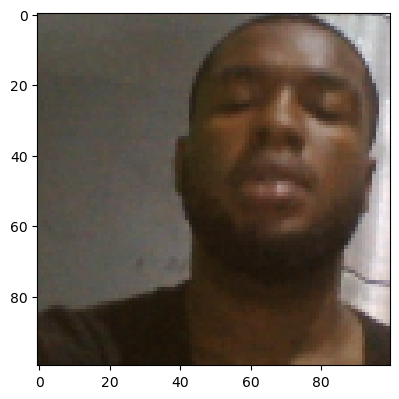

In [84]:
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.imshow(test_input[0])

plt.subplot(1,2,1)
plt.imshow(test_val[0])

plt.show()

In [101]:
application_data/verification_image


NameError: name 'application_data' is not defined

In [93]:
pwd

'c:\\Users\\hp\\OneDrive\\Desktop\\face recognition'

In [103]:
os.listdir(os.path.join('application_data', 'verification_images'))

['00a12d3b-0def-11ee-a7ec-0c84dc49c6f0.jpg',
 '00a8508c-0def-11ee-87c0-0c84dc49c6f0.jpg',
 '00af9321-0def-11ee-a350-0c84dc49c6f0.jpg',
 '00d353a8-0def-11ee-b7f6-0c84dc49c6f0.jpg',
 '00daab9d-0def-11ee-bcf1-0c84dc49c6f0.jpg',
 '00e6b407-0def-11ee-ac23-0c84dc49c6f0.jpg',
 '00ee0754-0def-11ee-995c-0c84dc49c6f0.jpg',
 '00f52e3e-0def-11ee-8606-0c84dc49c6f0.jpg',
 '01b6ad39-0def-11ee-87f8-0c84dc49c6f0.jpg',
 '01bdd847-0def-11ee-8a22-0c84dc49c6f0.jpg',
 '01c4dd29-0def-11ee-be7c-0c84dc49c6f0.jpg',
 '01f6ff11-0def-11ee-a8f9-0c84dc49c6f0.jpg',
 '02a57d3d-0def-11ee-98d2-0c84dc49c6f0.jpg',
 '02accd5f-0def-11ee-8a56-0c84dc49c6f0.jpg',
 '9b0fd8f8-0dee-11ee-89a1-0c84dc49c6f0.jpg',
 '9b99fe66-0dee-11ee-b701-0c84dc49c6f0.jpg',
 '9bc5a0f7-0dee-11ee-b646-0c84dc49c6f0.jpg',
 '9bccf2b2-0dee-11ee-a2ca-0c84dc49c6f0.jpg',
 '9c1682ee-0dee-11ee-9823-0c84dc49c6f0.jpg',
 '9c22b417-0dee-11ee-94c3-0c84dc49c6f0.jpg',
 '9c29c944-0dee-11ee-9f91-0c84dc49c6f0.jpg',
 '9c30e83b-0dee-11ee-bdb3-0c84dc49c6f0.jpg',
 '9c5011ed

In [104]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [105]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\00a12d3b-0def-11ee-a7ec-0c84dc49c6f0.jpg
application_data\verification_images\00a8508c-0def-11ee-87c0-0c84dc49c6f0.jpg
application_data\verification_images\00af9321-0def-11ee-a350-0c84dc49c6f0.jpg
application_data\verification_images\00d353a8-0def-11ee-b7f6-0c84dc49c6f0.jpg
application_data\verification_images\00daab9d-0def-11ee-bcf1-0c84dc49c6f0.jpg
application_data\verification_images\00e6b407-0def-11ee-ac23-0c84dc49c6f0.jpg
application_data\verification_images\00ee0754-0def-11ee-995c-0c84dc49c6f0.jpg
application_data\verification_images\00f52e3e-0def-11ee-8606-0c84dc49c6f0.jpg
application_data\verification_images\01b6ad39-0def-11ee-87f8-0c84dc49c6f0.jpg
application_data\verification_images\01bdd847-0def-11ee-8a22-0c84dc49c6f0.jpg
application_data\verification_images\01c4dd29-0def-11ee-be7c-0c84dc49c6f0.jpg
application_data\verification_images\01f6ff11-0def-11ee-a8f9-0c84dc49c6f0.jpg
application_data\verification_images\02a57d3d-0def-11ee-98d2-0c8

In [113]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [117]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 393ms/step
False
1/1 [==============================] - 0s 381ms/step
True
1/1 [==============================] - 0s 446ms/step
False
1/1 [==============================] - 0s 381ms/step
False


In [115]:
np.sum(np.squeeze(results) > 0.9)

0

In [116]:
results

[array([[0.50003934]], dtype=float32),
 array([[0.5001157]], dtype=float32),
 array([[0.5003348]], dtype=float32),
 array([[0.50060886]], dtype=float32),
 array([[0.50087]], dtype=float32),
 array([[0.5007391]], dtype=float32),
 array([[0.5006399]], dtype=float32),
 array([[0.50065744]], dtype=float32),
 array([[0.4993866]], dtype=float32),
 array([[0.49961695]], dtype=float32),
 array([[0.4996317]], dtype=float32),
 array([[0.49968907]], dtype=float32),
 array([[0.5003375]], dtype=float32),
 array([[0.5005324]], dtype=float32),
 array([[0.50061274]], dtype=float32),
 array([[0.5004425]], dtype=float32),
 array([[0.5002974]], dtype=float32),
 array([[0.50040597]], dtype=float32),
 array([[0.50043935]], dtype=float32),
 array([[0.5003066]], dtype=float32),
 array([[0.50032496]], dtype=float32),
 array([[0.50031686]], dtype=float32),
 array([[0.50031424]], dtype=float32),
 array([[0.50037897]], dtype=float32),
 array([[0.50020784]], dtype=float32),
 array([[0.5002565]], dtype=float32),
 